# Introduction to Computational Modeling in HCI

In [1]:
import matplotlib.pyplot as plt
import math
import numpy
numpy.set_printoptions(precision =2)
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import random

## Task 1 Define our keyboard

In [2]:
## Define our keyboard

line1 = 'qwertyuiop'
line2 = 'asdfghjkl'
line3 = 'zxcvbnm'

### Define a keyboard as a list of keys. Each key also mentions its position in the keyboard (line number, column number)
keyboard  = [(i, (0,ni)) for ni,i in enumerate(line1)] + [(i, (1,ni)) for ni,i in enumerate(line2)] + [(i, (2,ni)) for ni,i in enumerate(line3)]


### Define empty matrices to hold the results
ids = numpy.zeros((26,26))
Ds = numpy.zeros((26,26))
W = 1

alphabet = line1 + line2 + line3
keyboard_list = []

### Get Ids for each key combination
for ns,keystart in enumerate(alphabet):
    keyboard_list.append(keystart)
    for ne, keyend in enumerate(alphabet):
        
        xs,ys, xe,ye = keyboard[ns][1][1] + 2/5*keyboard[ns][1][0], keyboard[ns][1][0], keyboard[ne][1][1] + 2/5*keyboard[ne][1][0], keyboard[ne][1][0]
        ## Compute euclidian distance between the startkey and endkey
        D = math.sqrt((xe - xs)**2 + (ye - ys)**2)
        Ds[ns,ne] = D
        ## Use Fitts' law formula
        ids[ns,ne] = math.log2(1 + (D / W))

### This function can be used to print out an array in a form suited for a LaTex table. You can adapt it to print out the array in a different format if needed.

def bmatrix(a):
    text = r'$\left[\begin{array}{*{'
    text += str(len(a[0]))
    text += r'}c}'
    text += '\n'
    for x in range(len(a)):
        for y in range(len(a[x])):
            text += '{:.2f}'.format(a[x][y])
            text += r' & '
        text = text[:-2]
        text += r'\\'
        text += '\n'
    text += r'\end{array}\right]$'
    print(text)    
    

In [3]:
df = pd.DataFrame(ids)
df.columns = keyboard_list
df.index = keyboard_list
print(df)

          q         w         e         r         t         y         u  \
q  0.000000  1.000000  1.584963  2.000000  2.321928  2.584963  2.807355   
w  1.000000  0.000000  1.000000  1.584963  2.000000  2.321928  2.584963   
e  1.584963  1.000000  0.000000  1.000000  1.584963  2.000000  2.321928   
r  2.000000  1.584963  1.000000  0.000000  1.000000  1.584963  2.000000   
t  2.321928  2.000000  1.584963  1.000000  0.000000  1.000000  1.584963   
y  2.584963  2.321928  2.000000  1.584963  1.000000  0.000000  1.000000   
u  2.807355  2.584963  2.321928  2.000000  1.584963  1.000000  0.000000   
i  3.000000  2.807355  2.584963  2.321928  2.000000  1.584963  1.000000   
o  3.169925  3.000000  2.807355  2.584963  2.321928  2.000000  1.584963   
p  3.321928  3.169925  3.000000  2.807355  2.584963  2.321928  2.000000   
a  1.054524  1.115160  1.529469  1.920552  2.243763  2.512844  2.741701   
s  1.443853  1.054524  1.115160  1.529469  1.920552  2.243763  2.512844   
d  1.847997  1.443853  1.

Question: Explain why we can consider that the keys are square with dimension W = 1.   

Answer: In Equation (1), we can see the time MT is decided by the distance (D) and the target size (W). In our research, we want to model keyboard typing with a single finger. We know that each key on the keyboard is the same size, so when typing different words, the size has little influence on the time. If we consider W = 1, it's easy for computation and the MT is only dependent on the distance. Another explanation may be that the size contains width and height, but the equation doesn't specify which one should be computed. So we can consider that both the width and the height are 1, and the size is also 1. This meets the requirements of the equation.

## Task 2 Estimating Model parameters

R-squared: 0.708528
Standard error: 0.014609
slope: 0.11835088609159354
intercept: 0.04041064521015433
confidence intervals of slope: (0.09855306152551012, 0.14010871997573707)
confidence intervals of intercept: (-0.008491378658772676, 0.08698773985663089)


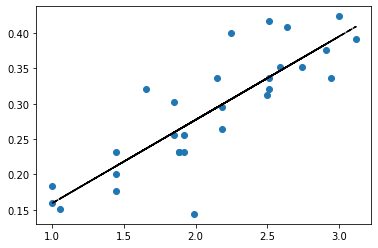

In [4]:
def get_keystrokes(filename, ids):
    ID, MT = [], []
    with open(filename, 'r') as _file:
        startime = 0
        for n,line in enumerate(_file):
#             print(n,line)
            try:
                startkey, stopkey, time = line.split(",")
#                 print(startkey, stopkey, time)
                time = float(time.rsplit('\n')[0])
                # if startkey == 'None':
                if n == 0:
                    startime = time
                    continue
                startkey = startkey.split("'")[1]
                stopkey = stopkey.split("'")[1]
                if startkey not in alphabet or stopkey not in alphabet:
                    continue
                ns = alphabet.index(startkey)
                ne = alphabet.index(stopkey)
                mt = time - startime
                MT.append(mt)
                ID.append(ids[ns,ne])
                startime = time
            except IndexError:
                pass
    return ID,MT



### Complete this function to estimate the parameters of Fitts' law
def analyse_keystrokes(ID,MT,ax):
    ax.plot(ID,MT,'o')

    slope, intercept, r_value, p_value, stderr = stats.linregress(ID, MT)
    # To get coefficient of determination (R-squared):
    print("R-squared: %f" % r_value**2)
    # stderr: how good of a fit the gradient is (higher values mean less precise) 
    print("Standard error: %f" % stderr)
    
    # assess the confidence of the estimated parameters
    n = len(MT)
    data = list(zip(ID, MT))
    list_slopes = []
    list_intercepts = []

    # repeated sampling
    for _ in range(100):
        sampled_data = [random.choice(data) for i in range(n)]
        x_s,y_s = zip(*sampled_data)
        x_s = numpy.array(x_s)
        y_s = numpy.array(y_s)

        m_s, b_s, r, p, err = stats.linregress(x_s,y_s)

        list_slopes.append(m_s)
        list_intercepts.append(b_s)
        
    # confidence interval of slopes
    mu_slope = numpy.mean(list_slopes)
    sigma_slope = numpy.std(list_slopes)
    ci_slope = stats.norm.interval(0.95, loc=mu_slope, scale=sigma_slope)
    
    # confidence interval of intercepts
    mu_intercept = numpy.mean(list_intercepts)
    sigma_intercept = numpy.std(list_intercepts)
    ci_intercept = stats.norm.interval(0.95, loc=mu_intercept, scale=sigma_intercept)
    
    print(f"slope: {slope}")
    print(f"intercept: {intercept}")
    print(f"confidence intervals of slope: {ci_slope}")
    print(f"confidence intervals of intercept: {ci_intercept}")

    return slope, intercept

ids = numpy.load('./id.npy')

#### Show how well Fitts' model fits: graphical representation, a goodness of fit of choice, and the uncertainty with regards to estimated parameters

fig = plt.figure()
ax = fig.add_subplot(111)
###TODO: use the get_keystrokes fucntion to get the IDs associated MT for each keystroke.
ID,MT = get_keystrokes('keystrokes.csv', ids)
####TODO: finish and use the analyse_keystrokes function to fit and plot Fitts' model.
slope, intercept = analyse_keystrokes(ID,MT,ax)
# print(slope, intercept)

f_MT = [i*slope+intercept for i in ID]

ax.plot(ID, f_MT, 'k--')
plt.show()

Analysis:
1. The goodness of fit  
(1) R-squared is a statistical measure of how close the data are to the fitted regression line. I get it 0.71 for the linear regression which means over 70% data is on the fitted regression line. The fit is not bad.  
(2) I also use the Standard Error to access the goodness. It tells how wrong the regression model is on average using the units of the response variable. Smaller values are better because it indicates that the observations are closer to the fitted line. I think the result 0.015 is fine.  
2. the confidence in the parameter values  
I try to use confidence interval to access the confidence in the parameter values. To get it, I repeat sampling multiple times and get a list of slopes and intercepts, and use `stats.norm.interval` to compute the confidence interval. The results are (0.1, 0.13) and (0, 0.08) separately.

## Task 3 Most Common words

Average time needed
0.9999165686462256


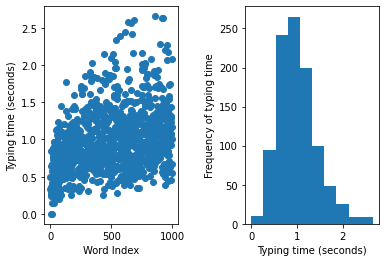

In [5]:
slope = 0.12
intercept = 0.03
with open("mostcommonwords.txt", 'r') as _file:
    T = []
    for nline, line in enumerate(_file):
        t = 0 ### initialize the typing time for a word
        line = line[:-1]
#         print(line, len(line))
        for i in range(0, len(line)-1):
            try:
                ns = alphabet.index(line[i])
                ne = alphabet.index(line[i+1])
                id = ids[ns,ne]
                ###TODO: increment typing time for each letter stroke
                t += (slope * id + intercept)
            except ValueError:
                pass
        T.append(t)

print("Average time needed")
print(numpy.mean(T))

fig = plt.figure()
ax = fig.add_subplot(121)
axhist = fig.add_subplot(122)

ax.plot(range(0,len(T)), T, 'o')
ax.set_ylabel("Typing time (seconds)")
ax.set_xlabel("Word Index")
###TODO: Plot the histogram of the typing times (use plt.hist() function )
axhist.hist(T)
axhist.set_xlabel('Typing time (seconds)')
axhist.set_ylabel('Frequency of typing time')
plt.subplots_adjust(wspace=0.5)
plt.show()
plt.close()

## Task 4 Modeling word frequency
I choose to estimate the `s` using logarithmic function since I see that the relation between logoc and logfreq is linear.  
$$p(k) = \frac{1/k^s}{\sum_{i=1}^{N} 1/i^s}$$
$$\log p(k) = -s\log(k) - \log(\sum_{i=1}^{N} 1/i^s)$$
$$\log frequency = \log(p(k)\times sum) = \log p(k) + \log sum = -s\log(k) - \log(\sum_{i=1}^{N} 1/i^s) + \log sum$$
Because N, sum, s are constants, the equation can be simplified as $$\log frequency = -s\log(k) + b$$
As a result, the `s` is just the opposite of the slope of the linear function. $$s = -slope$$

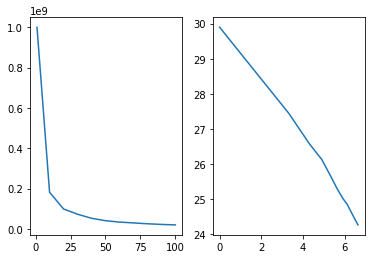

s: 0.8546543112841491


In [6]:
frequency = [1e9, 182e6, 99e6, 73e6, 53e6, 41e6, 34e6, 30e6, 25.7e6, 22.5e6, 20e6]
rank  = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

logfreq = [math.log(f,2) for f in frequency]
logoc = [math.log(o,2) for o in rank]

###TODO Fit Zipf's model to the frequencey-rank relationship, as explained in the assigment.

## Plot the data + fitted model
fig = plt.figure()
ax = fig.add_subplot(121)
axlog = fig.add_subplot(122)
ax.plot(rank, frequency, '-')

axlog.plot(logoc, logfreq)
plt.show()

slope, intercept, r_value, p_value, stderr = stats.linregress(logoc, logfreq)
s = -slope
print(f"s: {s}")


plot the fitted model using N = 100

Text(0, 0.5, 'Probability')

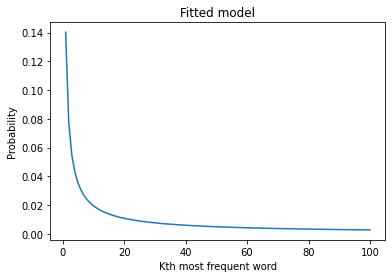

In [7]:
N = 100
x = range(1,101)
x_sum = numpy.sum([1 / i**s for i in x])
def func(x):
    return (1 / (x**s)) / x_sum

plt.plot(x, func(x))
plt.title('Fitted model')
plt.xlabel('Kth most frequent word')
plt.ylabel('Probability')

In [20]:
## Use this new information to evaluate the average time it takes to type the 1000 most common words
## Assume that there are only 1000 words in total, i.e. N = 1000. Skip the case of single letter words
s = 0.85

##TODO: Compute the normalizing sum (denominator) in the p(k) expression, with s = 0.85
_sum = numpy.sum([1 / i**s for i in range(1,1001)])

## TODO: compute the p(k)'s for each k
weights = []
for nt in range(1,1001):
    weight = (1 / nt**s) /_sum
    weights.append(weight)

weighted_sum = 0
for w,t in zip(weights, T):
    weighted_sum += w*t

print(weighted_sum)

0.7124495668649801


## Task 5 New keyboard layout

### Get the new ids

In [15]:
new_line1 = 'qwert'
new_line2 = 'yuiop'
new_line3 = 'asdfg'
new_line4 = 'hjkl'
new_line5 = 'zxcvbnm'


### Define a keyboard as a list of keys. Each key also mentions its position in the keyboard (line number, column number)
new_keyboard  = [(i, (0,ni)) for ni,i in enumerate(new_line1)] + [(i, (1,ni)) for ni,i in enumerate(new_line2)] + [(i, (2,ni)) for ni,i in enumerate(new_line3)] + [(i, (3,ni)) for ni,i in enumerate(new_line4)] + [(i, (4,ni)) for ni,i in enumerate(new_line5)]

### Define empty matrices to hold the results
new_ids = numpy.zeros((26,26))
Ds = numpy.zeros((26,26))
W = 1

alphabet = new_line1 + new_line2 + new_line3 + new_line4 + new_line5

### Get Ids for each key combination
for ns,keystart in enumerate(alphabet):
    for ne, keyend in enumerate(alphabet):
        xs,ys, xe,ye = new_keyboard[ns][1][1] + 2/5*new_keyboard[ns][1][0], new_keyboard[ns][1][0], new_keyboard[ne][1][1] + 2/5*new_keyboard[ne][1][0], new_keyboard[ne][1][0]
        ## Compute euclidian distance between the startkey and endkey
        D = math.sqrt((xe - xs)**2 + (ye - ys)**2)
        Ds[ns,ne] = D
        ## Use Fitts' law formula
        new_ids[ns,ne] = math.log2(1 + (D / W))

### Use Fitts' law to calculate the average time

Average time needed
0.9472428097811928


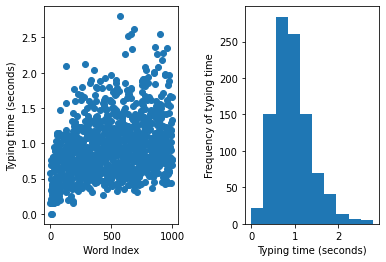

In [17]:
slope = 0.12
intercept = 0.03
with open("mostcommonwords.txt", 'r') as _file:
    new_T = []
    for nline, line in enumerate(_file):
        t = 0 ### initialize the typing time for a word
        line = line[:-1]
#         print(line, len(line))
        for i in range(0, len(line)-1):
            try:
                ns = alphabet.index(line[i])
                ne = alphabet.index(line[i+1])
                id = new_ids[ns,ne]
                ###TODO: increment typing time for each letter stroke
                t += slope * id + intercept
            except ValueError:
                pass
        new_T.append(t)

print("Average time needed")
print(numpy.mean(new_T))

fig = plt.figure()
ax = fig.add_subplot(121)
axhist = fig.add_subplot(122)

ax.plot(range(0,len(new_T)), new_T, 'o')
ax.set_ylabel("Typing time (seconds)")
ax.set_xlabel("Word Index")
###TODO: Plot the histogram of the typing times (use plt.hist() function )
axhist.hist(new_T)
axhist.set_xlabel('Typing time (seconds)')
axhist.set_ylabel('Frequency of typing time')
plt.subplots_adjust(wspace=0.5)
plt.show()
plt.close()

### Consider the word frequency and recalculate the average time

In [19]:
weighted_sum = 0
for w,t in zip(weights, new_T):
    weighted_sum += w*t

print(weighted_sum)

0.6741681764395243


### Discussion

why is changing the keyboard layout based on this analysis a bad idea ?

From the results above, the new keyboard saves a little typing time (0.67 vs 0.71 ). However, it's not a good idea to change the keyboard layout. The time saving is not so much, but users' habits are hard to change in a short time. Changing user behavior requires a lot of cost. In this case, it's not cost-effective to do this. Using unfamiliar keyboard layout would cause confusion for users and influence their use experience which are not designers want to see.